In [1]:
import os
import my_common_modules as my_modules
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from math import sqrt
from PIL import Image
import cv2
import itertools

4796 images found...
['.\\data\\synthetic_sugarbeat_galium\\rgb\\B_000186.png', '.\\data\\synthetic_sugarbeat_galium\\rgb\\A_000739.png', '.\\data\\synthetic_sugarbeat_galium\\rgb\\A_000729.png']


<Figure size 432x288 with 0 Axes>

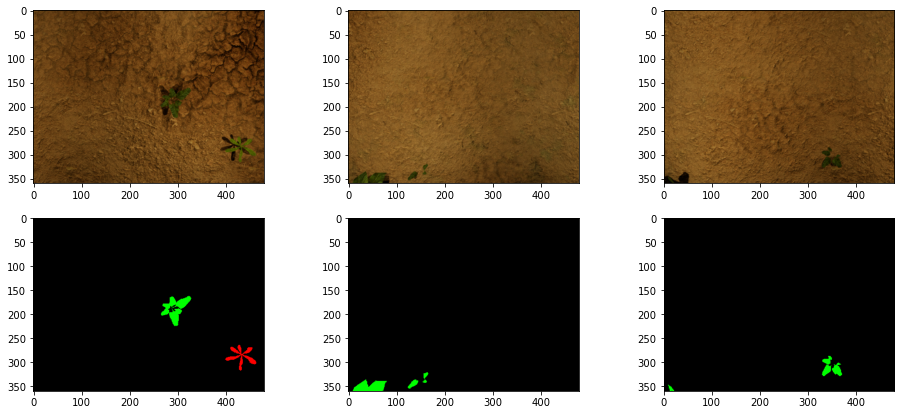

In [2]:
data_dir = '.\\data\\synthetic_sugarbeat_capsella\\'
image_filepaths1,label_filepaths1,color_filepaths1 = my_modules.import_dataset_filepaths("png","png", data_dir)
data_dir = '.\\data\\synthetic_sugarbeat_galium\\'
image_filepaths2,label_filepaths2,color_filepaths2 = my_modules.import_dataset_filepaths("png","png", data_dir)

image_filepaths = image_filepaths1 + image_filepaths2
label_filepaths = label_filepaths1 + label_filepaths2
color_filepaths = color_filepaths1 + color_filepaths2
image_count = len(image_filepaths)
print(str(image_count) + " images found...")
plt.figure()
seed = 65
random.seed(seed)
image_samples = random.sample(image_filepaths,3)
print(image_samples)
random.seed(seed)
label_samples = random.sample(label_filepaths,3)
random.seed(seed)
color_samples = random.sample(color_filepaths,3)
plt.figure(figsize=(16,7))
object_cnt = 1
for (img_fpath,col_fpath) in zip(image_samples, color_samples):
    img = cv2.imread(img_fpath)
    color_lbl = cv2.imread(col_fpath)
    plt.subplot(2,3,object_cnt)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(2,3,object_cnt+3)
    plt.imshow(cv2.cvtColor(color_lbl, cv2.COLOR_BGR2RGB))
    object_cnt += 1
rows = np.shape(img)[0]
cols = np.shape(img)[1]

## Identify plants that are unoccluded and not touching the edge

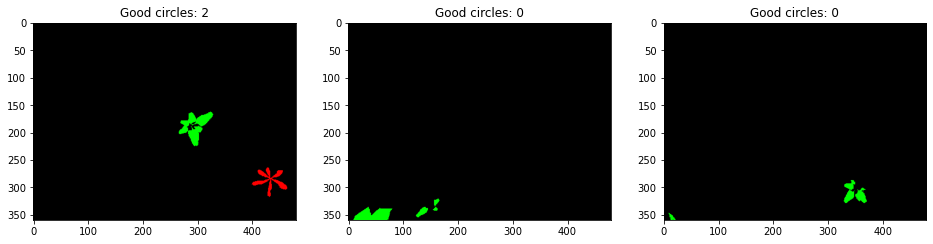

In [3]:
def checkTouchingCircles(xs,ys,rs,xmax,ymax,cnt):
    num_circles = len(xs)
    good_circles = []
    good_cnt = []
    for i in range(num_circles):
        isGood = True
        # Circles touching
        for j in range(num_circles):
            if i!=j:
                x = xs[i]-xs[j]
                y = ys[i]-ys[j]
                r = rs[i]+rs[j]
                d = sqrt(x*x + y*y)
                if (d <= r) and (d >= rs[i]): #are the circles touching but does not have the smaller circle inside it
                    isGood = False
                
        # Circle touching edge
        if (((xs[i]-rs[i])<=0) or ((xs[i]+rs[i])>=(xmax-1)) or ((ys[i]-rs[i])<=0) or ((ys[i]+rs[i])>=(ymax-1))):
            isGood = False
        
        # Is circle big enough
        if rs[i] < 20:
            isGood = False

        # Is circle good?
        if isGood:
            good_circles.append([xs[i],ys[i],rs[i]])
            good_cnt.append(cnt)
    return good_circles,good_cnt

def findGoodCircles(col_fpath):
    color_lbl = cv2.imread(col_fpath)
    g = color_lbl[:,:,1]
    r = color_lbl[:,:,2]
    white_mask = (g+r).astype('uint8')
    contours,hierarchy = cv2.findContours(white_mask, 0, 2)
    xs = []
    ys = []
    rs = []
    for cnt in contours:
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        xs.append(x)
        ys.append(y)
        rs.append(radius)
        center = (int(x),int(y))
        radius = int(radius)
        cv2.circle(white_mask,center,radius,160,2)
    #cv2.imshow("circle",white_mask)
    #cv2.waitKey(0)
    good_circles,good_cnt = checkTouchingCircles(xs,ys,rs,cols,rows,contours)
    return good_circles, good_cnt

plt.figure(figsize=(16,5))
object_cnt = 1
for (img_fpath,lbl_fpath,col_fpath) in zip(image_samples,label_samples,color_samples):
    good_circles, good_cnt = findGoodCircles(col_fpath)
    rgb_img = cv2.imread(img_fpath)
    lbl = cv2.imread(lbl_fpath,cv2.IMREAD_GRAYSCALE)
    col_lbl = cv2.imread(col_fpath)
    for circle in good_circles:
        center = (int(circle[0]),int(circle[1]))
        radius = int(circle[2])
        
        #make cutouts
        cutout_rgb = np.zeros([int(2*radius),int(2*radius),3])
        cutout_gt = np.zeros([int(2*radius),int(2*radius)])
        cutout_gt_color = np.zeros([int(2*radius),int(2*radius),3])
        cutout_mask = np.zeros([int(2*radius),int(2*radius),3],dtype='uint8')
        cv2.circle(cutout_mask,[radius,radius],radius,[1,1,1],-1)
        new_m = 0
        for m in range(int(center[1]-radius),int(center[1]+radius)):
            new_n = 0
            for n in range(int(center[0]-radius),int(center[0]+radius)):
                if (lbl[m,n]>0):
                    cutout_rgb[new_m,new_n,:] = rgb_img[m,n,:]
                    cutout_gt[new_m,new_n] = lbl[m,n]
                    cutout_gt_color[new_m,new_n,:] = col_lbl[m,n,:]
                    if (lbl[m,n]==2 and ('galium' in img_fpath)):
                        cutout_gt_color[new_m,new_n,:] = [255,0,0]
                new_n += 1
            new_m += 1
            
        #Masking out corners outside circle
        cutout_rgb = np.multiply(cutout_rgb,cutout_mask).astype('uint8')
        cutout_gt = np.multiply(cutout_gt,cutout_mask[:,:,0]).astype('uint8')
        cutout_gt_color = np.multiply(cutout_gt_color,cutout_mask).astype('uint8')
        
        #cv2.imshow("circle",cutout_gt_color)
        #cv2.waitKey(0)
        #cv2.circle(col_lbl,center,radius,(255,255,255),2)
        
    plt.subplot(1,3,object_cnt)
    plt.title('Good circles: '+str(len(good_circles)))
    plt.imshow(cv2.cvtColor(col_lbl, cv2.COLOR_BGR2RGB))
    
    
    
    object_cnt += 1
        
plt.show()

## Find all good plants

In [4]:
img_cnt = 0
total_sugarbeat = 0
total_galium = 0
total_capsella = 0

for (img_fpath,lbl_fpath,col_fpath) in zip(image_filepaths,label_filepaths,color_filepaths):
    good_circles, good_cnt = findGoodCircles(col_fpath)
    rgb_img = cv2.imread(img_fpath)
    lbl = cv2.imread(lbl_fpath,cv2.IMREAD_GRAYSCALE)
    col_lbl = cv2.imread(col_fpath)
    count = len(good_circles)
        
    for circle in good_circles:
        center = (int(circle[0]),int(circle[1]))
        radius = int(circle[2])
        
        #make cutouts
        cutout_rgb = np.zeros([int(2*radius),int(2*radius),3])
        cutout_gt = np.zeros([int(2*radius),int(2*radius)])
        cutout_gt_color = np.zeros([int(2*radius),int(2*radius),3])
        cutout_mask = np.zeros([int(2*radius),int(2*radius),3],dtype='uint8')
        cv2.circle(cutout_mask,[radius,radius],radius,[1,1,1],-1)
        new_m = 0
        for m in range(int(center[1]-radius),int(center[1]+radius)):
            new_n = 0
            for n in range(int(center[0]-radius),int(center[0]+radius)):
                if (lbl[m,n]>0):
                    cutout_rgb[new_m,new_n,:] = rgb_img[m,n,:]
                    cutout_gt[new_m,new_n] = lbl[m,n]
                    cutout_gt_color[new_m,new_n,:] = col_lbl[m,n,:]
                    if (lbl[m,n]==2 and ('galium' in img_fpath)):
                        cutout_gt_color[new_m,new_n,:] = [255,0,0]
                        cutout_gt[new_m,new_n] = 3
                new_n += 1
            new_m += 1
            
        #Masking out corners outside circle
        cutout_rgb = np.multiply(cutout_rgb,cutout_mask).astype('uint8')
        cutout_gt = np.multiply(cutout_gt,cutout_mask[:,:,0]).astype('uint8')
        cutout_gt_color = np.multiply(cutout_gt_color,cutout_mask).astype('uint8')
        
        if (np.max(cutout_gt)==1):
            total_sugarbeat += 1
            zero_filled_number = str(total_sugarbeat).zfill(4)
            out_dir = '.\\data\\sugarbeat\\'
            cv2.imwrite(out_dir+'rgb\\'+zero_filled_number+'.png',cutout_rgb,(cv2.IMWRITE_JPEG_QUALITY,100))
            cv2.imwrite(out_dir+'gt\\'+zero_filled_number+'.png',cutout_gt,(cv2.IMWRITE_JPEG_QUALITY,100))
            cv2.imwrite(out_dir+'gt_color\\'+zero_filled_number+'.png',cutout_gt_color,(cv2.IMWRITE_JPEG_QUALITY,100))
            
        if (np.max(cutout_gt)==2):
            total_capsella += 1
            zero_filled_number = str(total_capsella).zfill(4)
            out_dir = '.\\data\\capsella\\'
            cv2.imwrite(out_dir+'rgb\\'+zero_filled_number+'.png',cutout_rgb,(cv2.IMWRITE_JPEG_QUALITY,100))
            cv2.imwrite(out_dir+'gt\\'+zero_filled_number+'.png',cutout_gt,(cv2.IMWRITE_JPEG_QUALITY,100))
            cv2.imwrite(out_dir+'gt_color\\'+zero_filled_number+'.png',cutout_gt_color,(cv2.IMWRITE_JPEG_QUALITY,100))
        elif (np.max(cutout_gt)==3):
            total_galium += 1
            zero_filled_number = str(total_galium).zfill(4)
            out_dir = '.\\data\\galium\\'
            cv2.imwrite(out_dir+'rgb\\'+zero_filled_number+'.png',cutout_rgb,(cv2.IMWRITE_JPEG_QUALITY,100))
            cv2.imwrite(out_dir+'gt\\'+zero_filled_number+'.png',cutout_gt,(cv2.IMWRITE_JPEG_QUALITY,100))
            cv2.imwrite(out_dir+'gt_color\\'+zero_filled_number+'.png',cutout_gt_color,(cv2.IMWRITE_JPEG_QUALITY,100))
            
print("Total sugarbeats: " + str(total_sugarbeat))
print("Total capsella: " + str(total_capsella))
print("Total galium: " + str(total_galium))


Total sugarbeats: 836
Total capsella: 385
Total galium: 1036
